<a href="https://colab.research.google.com/github/Sandeep2017/Crack-segmentation-in-concrete-structures-using-U-Net/blob/master/Crack_Segmentation_UNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


In [0]:
# Set some parameters
im_width = 128
im_height = 128
border = 5

In [0]:
ids = next(os.walk("..input/Datasets/crack/train"))[2] # list of names all images in the given path
print("No. of images = ", len(ids))

No. of images =  100


In [0]:
X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)

In [0]:
# tqdm is used to display the progress bar
for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
    # Load images
    img = load_img("..input/Datasets/crack/train/"+id_, grayscale=True)
    x_img = img_to_array(img)
    x_img = resize(x_img, (128, 128, 1), mode = 'constant', preserve_range = True)
    # Load masks
    mask = img_to_array(load_img("..input/Datasets/crack/mask/"+id_, grayscale=True))
    mask = resize(mask, (128, 128, 1), mode = 'constant', preserve_range = True)
    # Save images
    X[n] = x_img/255.0
    y[n] = mask/255.0

In [0]:
# Split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

In [0]:
print(len(X_train),len(y_train))
print(len(X_valid),len(y_valid))

90 90
10 10


Text(0.5, 1.0, 'Salt')

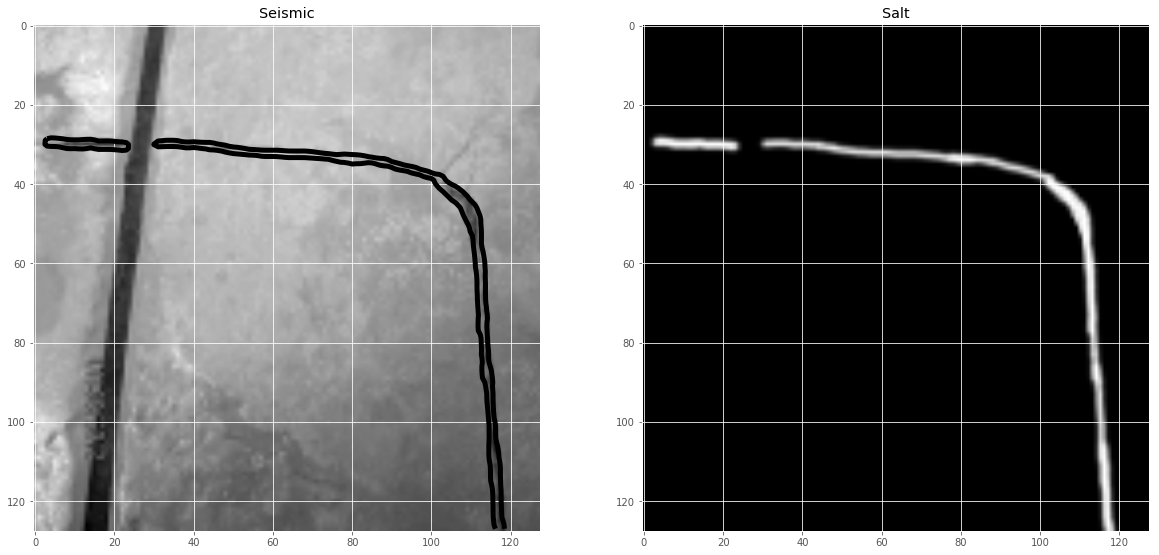

In [0]:
# Visualize any randome image along with the mask
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 # salt indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[ix, ..., 0], cmap = 'gray', interpolation = 'bilinear')
if has_mask: # if salt
    # draw a boundary(contour) in the original image separating salt and non-salt areas
    ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('Seismic')

ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Salt')

In [0]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [0]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [0]:
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

In [0]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_59 (Conv2D)              (None, 128, 128, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_56 (BatchNo (None, 128, 128, 16) 64          conv2d_59[0][0]                  
__________________________________________________________________________________________________
activation_56 (Activation)      (None, 128, 128, 16) 0           batch_normalization_56[0][0]     
__________________________________________________________________________________________________
max_poolin

In [0]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-tgs-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [0]:
results = model.fit(X_train, y_train, batch_size=32, epochs=50, callbacks=callbacks,\
                    validation_data=(X_valid, y_valid))

Train on 90 samples, validate on 10 samples
Epoch 1/50
90/90 [==============================] - ETA: 17s - loss: 1.4473 - acc: 0.05 - ETA: 6s - loss: 1.4231 - acc: 0.0456 - 21s 229ms/step - loss: 1.3988 - acc: 0.0420 - val_loss: 2.4645 - val_acc: 0.0279

Epoch 00001: val_loss improved from inf to 2.46455, saving model to model-tgs-salt.h5
Epoch 2/50
90/90 [==============================] - ETA: 9s - loss: 1.2845 - acc: 0.029 - ETA: 4s - loss: 1.2637 - acc: 0.030 - 16s 175ms/step - loss: 1.2405 - acc: 0.0313 - val_loss: 4.8144 - val_acc: 0.0569

Epoch 00002: val_loss did not improve from 2.46455
Epoch 3/50
90/90 [==============================] - ETA: 9s - loss: 1.1292 - acc: 0.041 - ETA: 4s - loss: 1.0952 - acc: 0.048 - 16s 176ms/step - loss: 1.0765 - acc: 0.0571 - val_loss: 3.3227 - val_acc: 0.1735

Epoch 00003: val_loss did not improve from 2.46455
Epoch 4/50
90/90 [==============================] - ETA: 9s - loss: 1.0123 - acc: 0.090 - ETA: 4s - loss: 0.9557 - acc: 0.129 - 16s 174ms

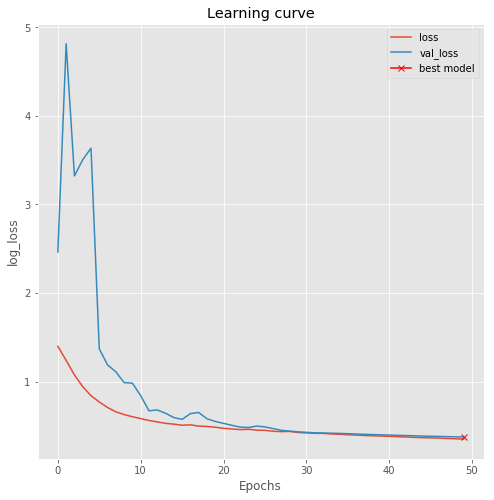

In [0]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

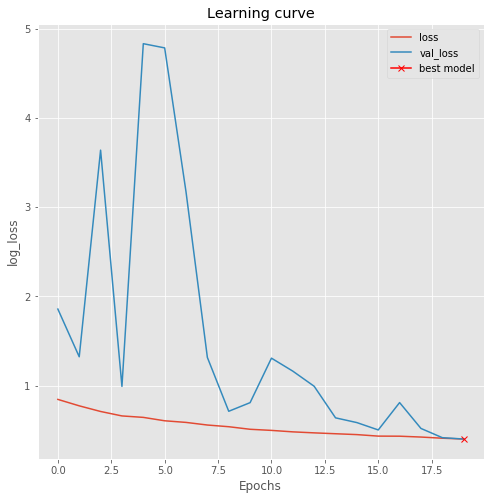

In [0]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

### Inference

In [0]:
# load the best model
model.load_weights('model-tgs-salt.h5')

In [0]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_valid, y_valid, verbose=1)

10/10 [==============================] - 0s 34ms/step


[0.37583211064338684, 0.9352477788925171]

In [0]:
print(len(X_valid))
print(len(y_valid))

10
10


In [0]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

10/10 [==============================] - 0s 36ms/step


In [0]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [0]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='gray')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Seismic')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Crack')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Crack Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Crack Predicted binary');

### Predictions on training set

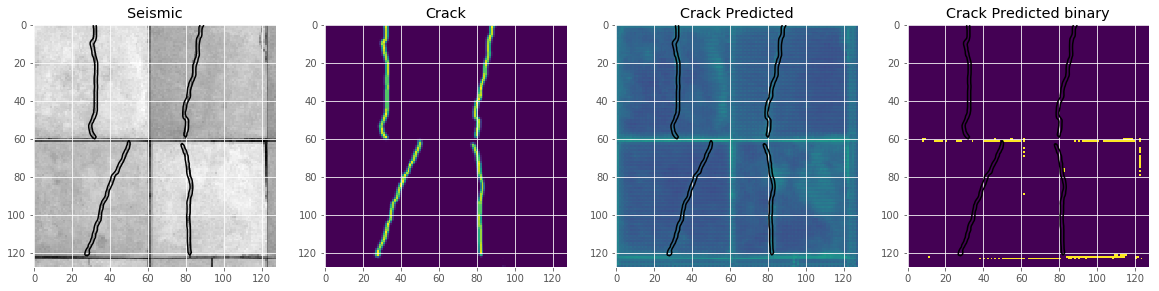

In [0]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=79)

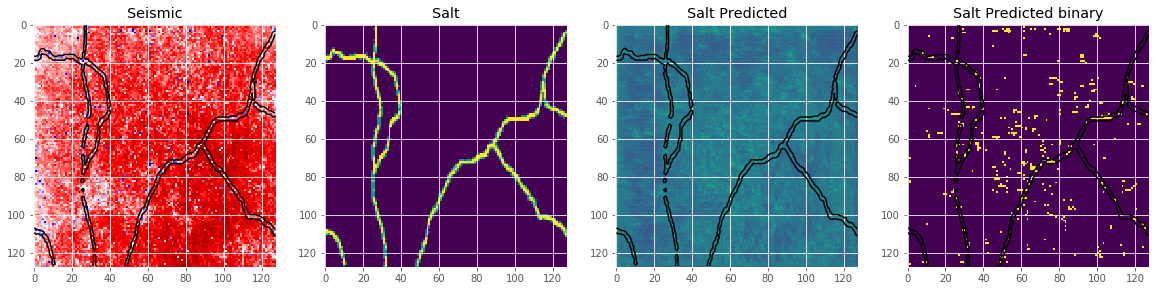

In [0]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

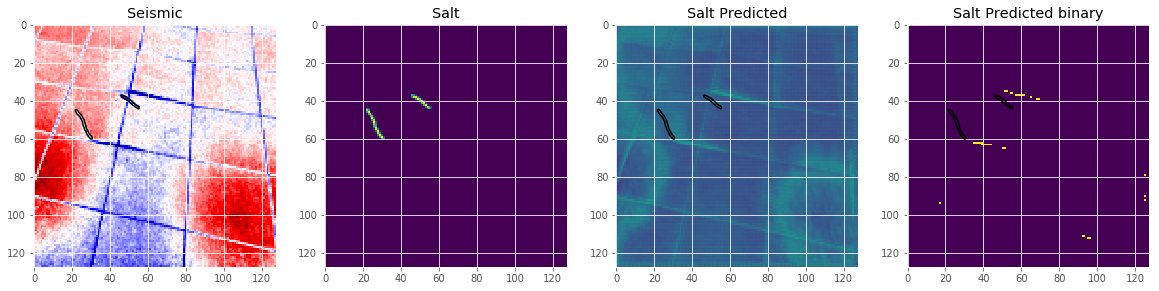

In [0]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

### Predictions on test set

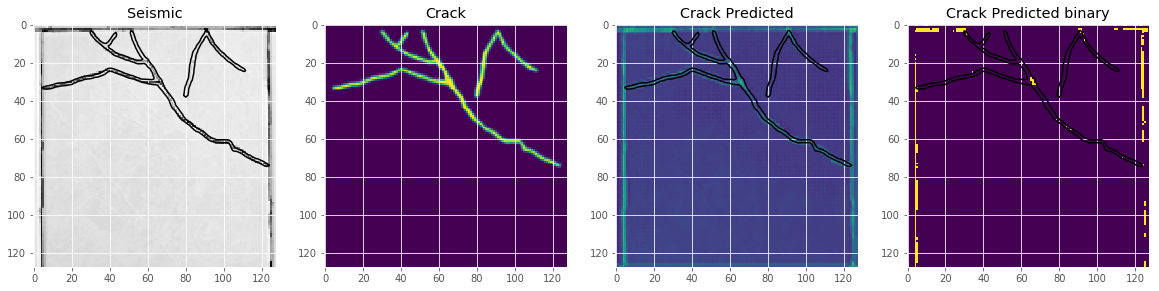

In [0]:
# Check if valid data looks all right
# For 20 epochs 
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=0)

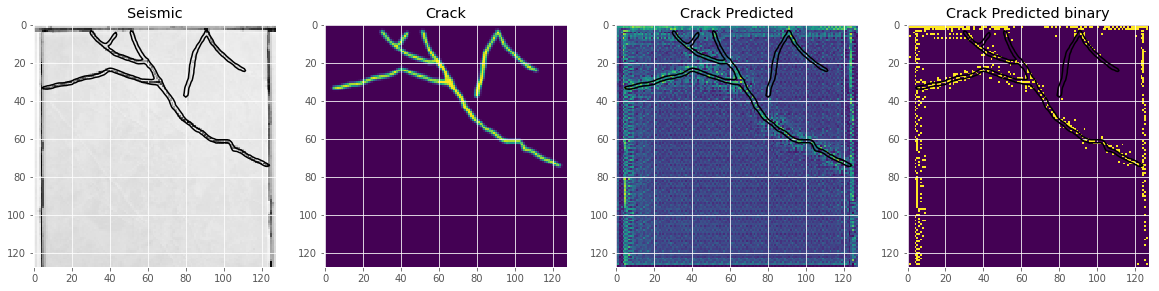

In [0]:
#For just 1 epoch
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=0)

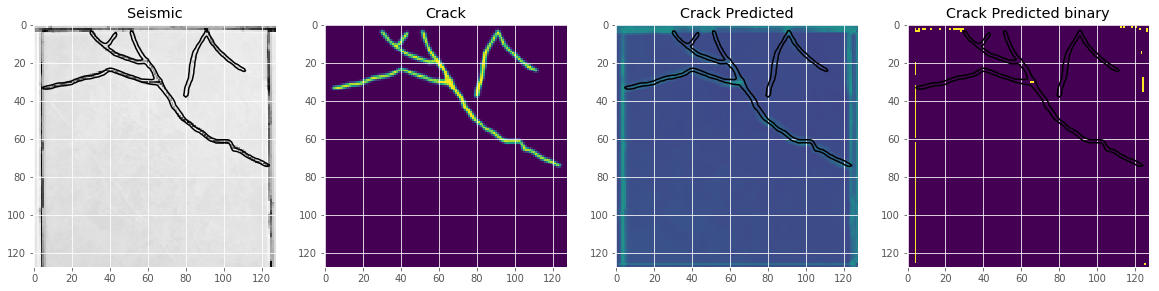

In [0]:
#For 50 epochs
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=0)

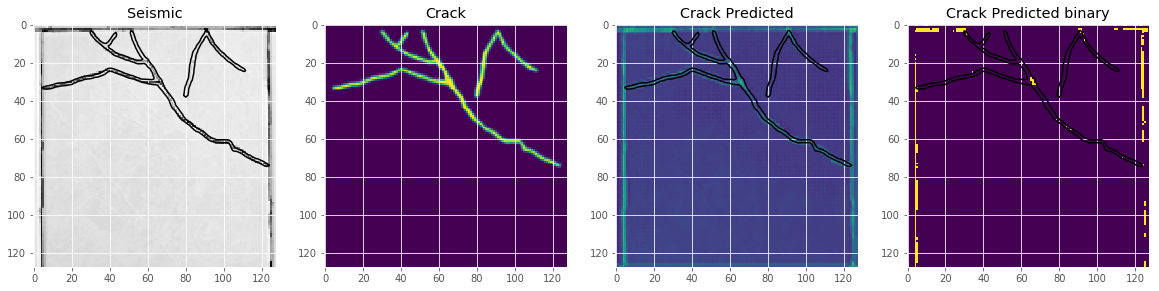

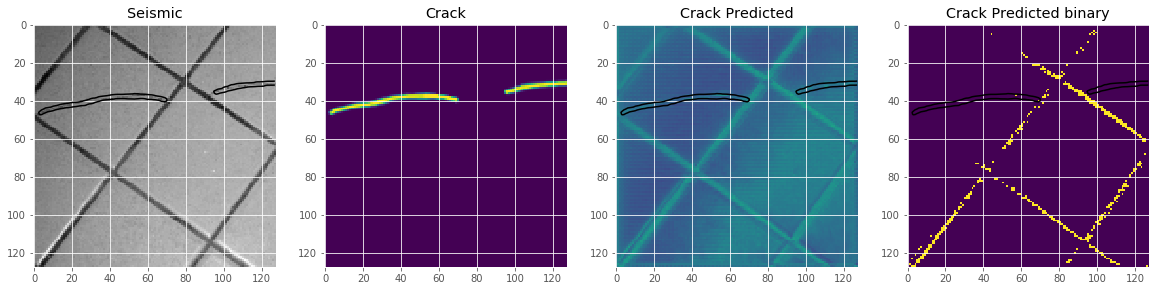

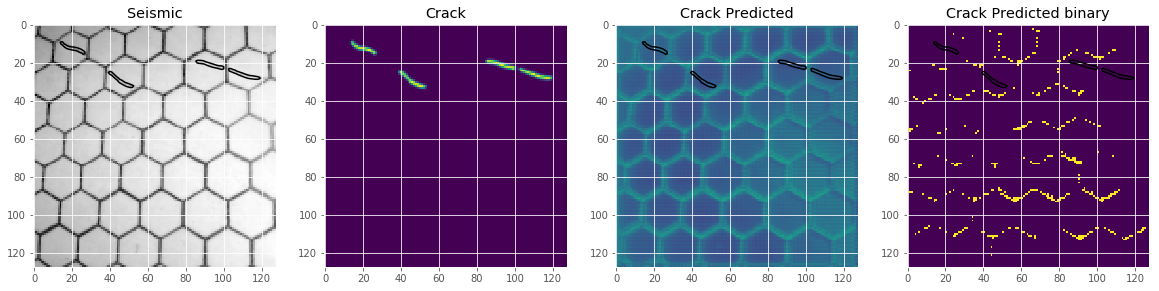

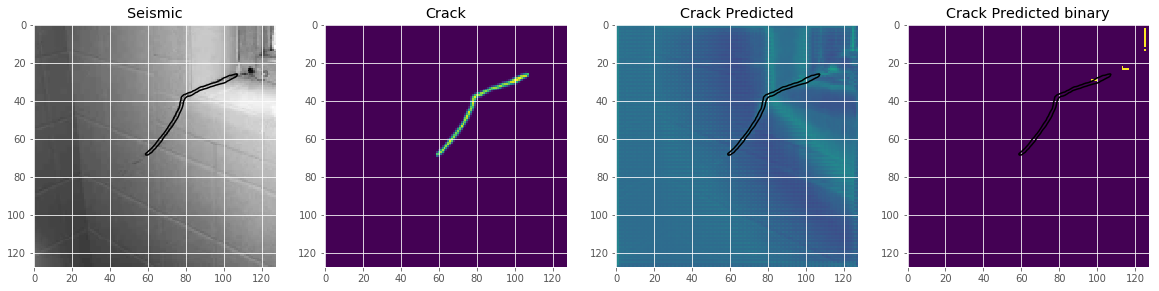

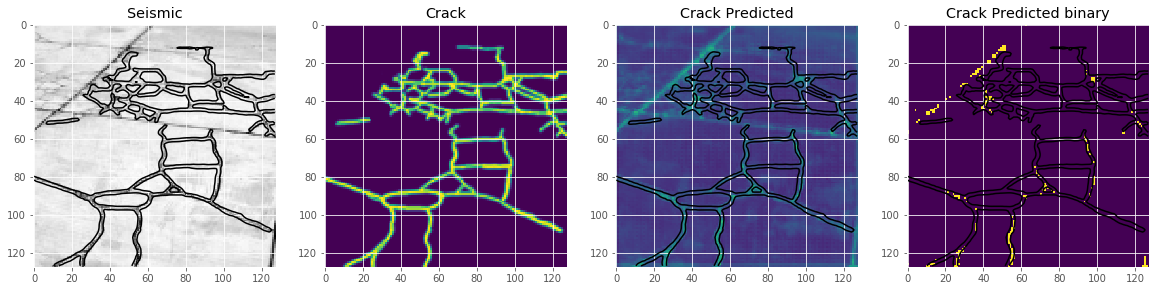

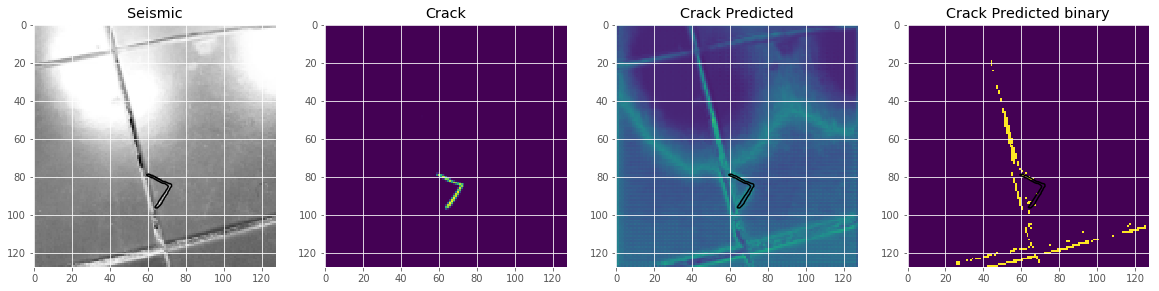

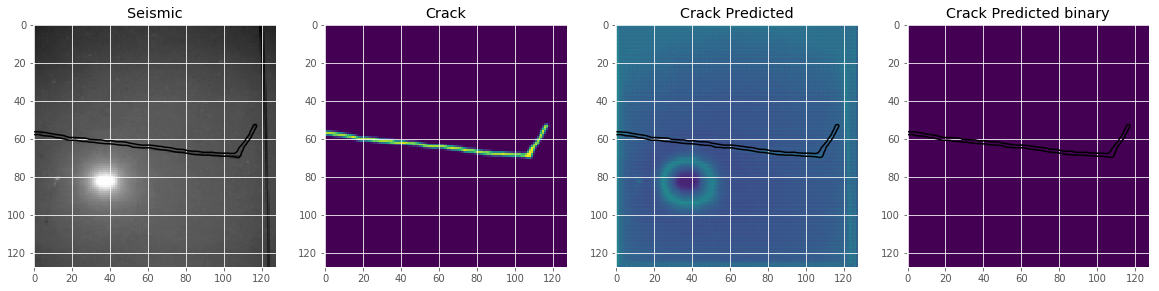

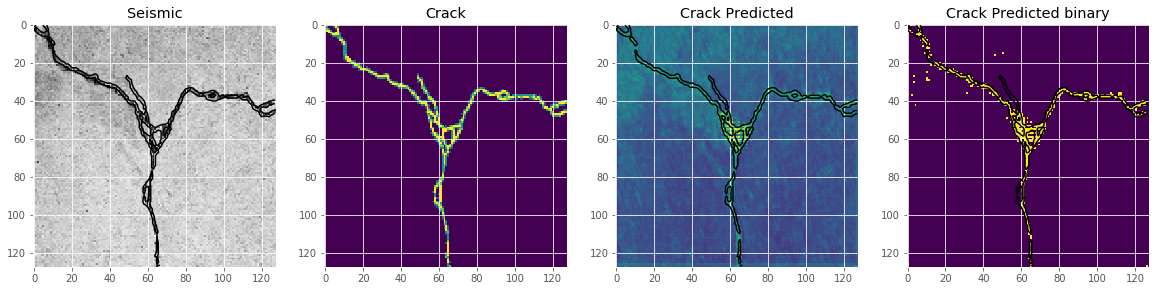

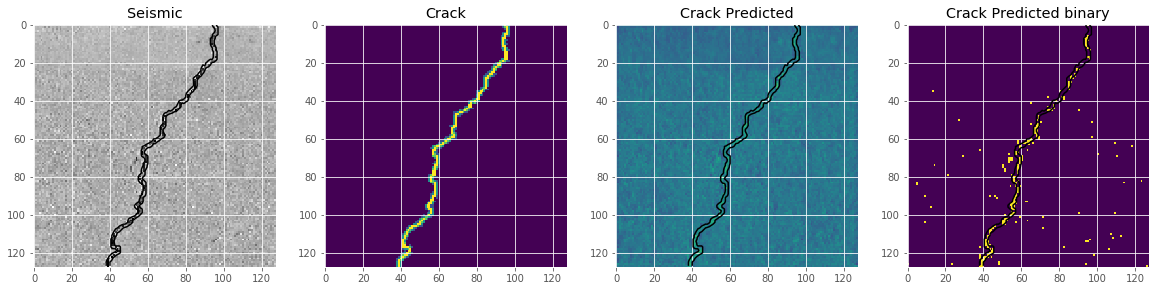

In [0]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=0)
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=1)
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=2)
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=3)
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=4)
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=5)
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=7)
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=8)
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=9)
#plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=10)